In [347]:
from sparse_pca import *
import pandas as pd
from sklearn.decomposition import SparsePCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from scipy.linalg import orth
import numpy as np

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{siunitx}')

Load the dataset

In [348]:
X_small = pd.read_csv("../Data/BreastTissue.csv").drop(['Case #'],axis = 1).drop(['Class'],axis=1).to_numpy()
y_small = pd.read_csv("../Data/BreastTissue.csv").drop(['Case #'],axis = 1)['Class'].to_numpy()

y_small = preprocessing.LabelEncoder().fit_transform(y_small)

In [358]:
class PCAObject:
    def __init__(self, PCs, X, label):
        assert len(PCs) == min(X.shape[0],X.shape[1]), "Need all the principal components!"
        self.pcs = PCs
        self.X = StandardScaler().fit_transform(X)
        self.cov = np.cov(self.X.T)
        self.label = label
        
        self._calcExpVar()
        self._calcNonZeroLoads()
        self._calcGini()
        self._calcSparsity()    
    
    def _checkOrtho(self):
        # Check if the Principal components are orthogonal
        norm = np.linalg.norm(self.pcs @ self.pcs.T - np.identity(len(self.pcs)))
        return norm < 1e-2
    
    def _calcExpVar(self):
        self.ev = Adj_Var(StandardScaler().fit_transform(self.X), self.pcs)
        self.pev = self.ev/np.sum(self.ev)
        self.cev = np.cumsum(np.flip(np.sort(self.pev)))
        self.evd = gini(np.asarray(self.pev))
        
    def _calcNonZeroLoads(self):
        self.nonZeroLoads = [np.count_nonzero(pc) for pc in self.pcs]
        
    def _calcGini(self):
        self.gini = [gini(abs(i)) for i in self.pcs]
        
    def _calcSparsity(self):
        self.sparsity = np.sum([gini * pev for gini, pev in zip(self.gini, self.pev)])
        
    def plotNonZeroLoadtoPEV(self):
        plt.plot(self.nonZeroLoads, self.pev, label=self.label)
        plt.xlabel('Number of non-zero loadings')
        plt.xscale('log')
        plt.ylabel('Percentage of explained variance (PEV)')
        plt.ylim((0,1))
        plt.legend()
        plt.title('Percentage of explained variance (PEV) vs non-zero loadings')
        
    def plotCEV(self):
        x = np.arange(len(self.pcs))
        
        plt.plot(x, np.sort(self.cev), label = self.label)
        plt.xlabel('Number of component')
        plt.ylabel('Cumulative explained variance')
        plt.xlim((0,8))
        plt.legend()
        plt.title('Cumulative explained variance')
        
    def plotSparsitytoEV(self,k): #k is which PC you want to plot
        plt.scatter(self.gini[k], self.ev[k], label = self.label)
        plt.xlabel('Sparsity of PC '+str(k+1))
        plt.ylabel('Explained variance of PC '+str(k+1))
        plt.legend()
        plt.title('Sparsity of PC versus expained variance of PC '+str(k+1))
        
    def plotSparsity(self):
        x = np.arange(len(self.pcs))
        y = np.array(self.gini)[np.flip(np.argsort(self.ev))]
        #y = np.flip(np.sort(self.gini))
        
        plt.scatter(x, y)
        plt.plot(x, y, label = self.label)
        plt.xlabel('Number of component')
        plt.ylabel('Sparsity of loadings')
        plt.legend()
        plt.title('Sparsity of components')

We want four rows: PCA, SCoT, SCoTLASS, SPCA for their "best" specification. We will show the difference within each model in tables and figures in the appendix. Columns containing: Weighted Gini coefficient, distribution of explained variance

In [356]:
def table_builder(function, params, X):
    if len(params.keys()) > 0:
        results_table = pd.DataFrame(params)
        results_table = results_table.set_index(list(params.keys()))
    else:
        results_table = pd.DataFrame(index = [1])

    for column in ['Concentration of EV', 'Sparsity', 'Run Time (sec)']:
        results_table[column] = np.nan

    for index, row in results_table.iterrows():
        start = datetime.now()
        if len(params.keys()) == 0:
            PCs = function(X)
        elif len(params.keys()) == 1:
            PCs = function(X, index)
        else:
            PCs = function(X, index[0], index[1])
        obj = PCAObject(PCs, X_small, "")
        obj._calcGini()
        obj._calcExpVar()
        obj._calcSparsity()
        stop = datetime.now()

        evd = obj.evd
        spa = obj.sparsity
        runtime = "{runtime:d}".format(runtime = (stop - start).seconds)
        results_table.loc[index] = [evd, spa, runtime]
    return results_table

In [351]:
def function(X):
    return reg_PCA(X)[1]
params = {}
PCA_df = table_builder(function, params, X_small)
with open('../Tables/PCA.tex', 'w') as file:
        file.write(PCA_df.to_latex(column_format = "cccc",
                                   index = False,
                                   float_format = "%.2f",
                                   escape = False))

In [310]:
def function(X, reg):
    return SCoT(X, reg, alpha = 10**-6,max_iter = 500000)
params = {r"$\theta$": [600, 685, 800, 900]}
SCoT_df = table_builder(function, params, X_small)
with open('../Tables/SCoT.tex', 'w') as file:
        file.write(SCoT_df.to_latex(column_format = "r|cccc",
                                    float_format = "%.2f",
                                    escape = False))

In [311]:
def function(X, reg):
    return SCoTLASS(X, reg, alpha = 10**-6,max_iter = 500000)
params = {"$t$": [1, 1.5, 2, 2.5]}
SCoTLASS_df = table_builder(function, params, X_small)
with open('../Tables/SCoTLASS.tex', 'w') as file:
        file.write(SCoTLASS_df.to_latex(column_format = "r|cccc",
                                        float_format = "%.2f",
                                        escape = False))

In [372]:
def function(X, reg, reg2):
    X = StandardScaler().fit_transform(X)
    transformer = SparsePCA(n_components = 9, alpha = reg, ridge_alpha = reg2)
    transformer.fit(X)
    norm_comps = [i/np.linalg.norm(i) for i in transformer.components_]
    return norm_comps
params = {"$\lambda_1$": [0.0001,0.001, 0.01, 0.1], 
          "$\lambda_2$": [0.1,0.1,0.1,0.1]}
SPCA_df = table_builder(function, params, X_small)
with open('../Tables/SPCA.tex', 'w') as file:
        file.write(SPCA_df.to_latex(column_format = "rr|cccc",
                                    float_format = "%.2f",
                                    escape = False))

In [239]:
def spca(X, reg, reg2): 
    X = StandardScaler().fit_transform(X)
    transformer = SparsePCA(n_components = 9, alpha = reg, ridge_alpha = reg2)
    transformer.fit(X)
    norm_comps = [i/np.linalg.norm(i) for i in transformer.components_]
    return norm_comps

In [240]:
def scot_wrapper(reg_param):
    PCs = PCAObject(SCoT(X_small, reg_param, alpha = 10**-2, max_iter = 5e5), X_small, " ")
    PCs._calcGini()
    return PCs.sparsity

In [241]:
reg_params = np.geomspace(0.01, 1000, num = 10).reshape(-1,1)
plot = np.apply_along_axis(scot_wrapper, axis = 1, arr = reg_params)

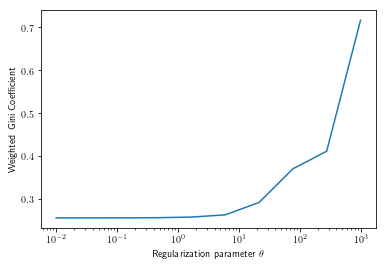

In [352]:
plt.plot(reg_params, plot)
plt.xlabel(r"Regularization parameter $\theta$")
plt.xscale("log")
plt.ylabel("Weighted Gini Coefficient")
plt.show()

0.5565021295764983
0.366230800052187
0.19630463204312645
0.21393567387014134


array([0.16588405, 0.19630463, 0.11520471, 0.1078082 , 0.09610008,
       0.08309241, 0.08721188, 0.07107712, 0.0773169 ])

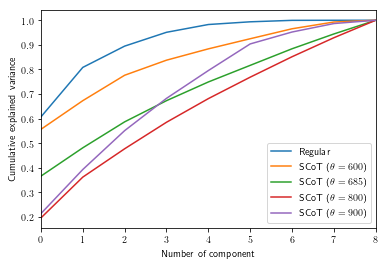

In [371]:
reg_reg.plotCEV()
reg_scot_600.plotCEV()
reg_scot_685.plotCEV()
reg_scot_800.plotCEV()
reg_scot_900.plotCEV()
plt.title("")
plt.savefig("../Figures/SCoT_comparison.pdf", bbox_inches = 'tight')

print(reg_scot_600.cev[0])
print(reg_scot_685.cev[0])
print(reg_scot_800.cev[0])
print(reg_scot_900.cev[0])

reg_scot_800.pev

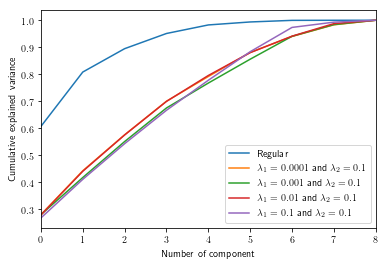

In [368]:
params = {"$\lambda_1$": [0.0001, 0.001, 0.01, 0.1], 
          "$\lambda_2$": [0.1, 0.1, 0.1, 0.1]}

spca = SparsePCA(n_components = 9, alpha = 0.0001, ridge_alpha = 0.1).fit(X_small).components_
reg_spca_pt0001 = PCAObject(spca, X_small, r"$\lambda_1 = 0.0001$ and $\lambda_2 = 0.1$")

spca = SparsePCA(n_components = 9, alpha = 0.001, ridge_alpha = 0.1).fit(X_small).components_
reg_spca_pt001 = PCAObject(spca, X_small, r"$\lambda_1 = 0.001$ and $\lambda_2 = 0.1$")

spca = SparsePCA(n_components = 9, alpha = 0.01, ridge_alpha = 0.1).fit(X_small).components_
reg_spca_pt01 = PCAObject(spca, X_small, r"$\lambda_1 = 0.01$ and $\lambda_2 = 0.1$")

spca = SparsePCA(n_components = 9, alpha = 0.1, ridge_alpha = 0.1).fit(X_small).components_
reg_spca_pt1 = PCAObject(spca, X_small, r"$\lambda_1 = 0.1$ and $\lambda_2 = 0.1$")

reg_reg.plotCEV()
reg_spca_pt0001.plotCEV()
reg_spca_pt001.plotCEV()
reg_spca_pt01.plotCEV()
reg_spca_pt1.plotCEV()
plt.title("")
plt.savefig("../Figures/SPCA_comparison.pdf", bbox_inches = 'tight')

In [286]:
results_table = pd.DataFrame({'Model': ['PCA', r"SCoT ($\theta = 685$)", 
                                      "SCoTLASS ($t = 2$)", 
                                      "SPCA ($\lambda_1=0.001$ and $\lambda_2=0.1$)"]})
for column in ['Concentration of EV', 'Sparsity', 'Run Time (sec)']:
        results_table[column] = np.nan
results_table = results_table.set_index('Model')

start = datetime.now()
reg_reg = PCAObject(reg_PCA(X_small)[1], X_small, "PCA")
stop = datetime.now()
results_table.loc["PCA"] = [reg_reg.evd, 
                            reg_reg.sparsity, 
                            "{runtime:d}".format(runtime = (stop - start).seconds)]


start = datetime.now()
reg_scot_685 = PCAObject(SCoT(X_small, 685, alpha = 10**-6, max_iter = 500000), 
                          X_small, r"SCoT ($\theta = 685$)")
stop = datetime.now()
results_table.loc[r"SCoT ($\theta = 685$)"] = [reg_scot_685.evd, 
                                                reg_scot_685.sparsity, 
                                                "{runtime:d}".format(runtime = (stop - start).seconds)]

start = datetime.now()
reg_scotlass_2 = PCAObject(SCoTLASS(X_small,2,alpha = 10**-6, max_iter=500000), 
                              X_small, "SCoTLASS ($t = 2$)")
stop = datetime.now()
results_table.loc["SCoTLASS ($t = 2$)"] = [reg_scotlass_2.evd, 
                            reg_scotlass_2.sparsity, 
                            "{runtime:d}".format(runtime = (stop - start).seconds)]

start = datetime.now()
reg_spca_pt001 = PCAObject(SparsePCA(n_components = 9, alpha = 0.001, ridge_alpha = 0.1).fit(X_small).components_, 
                              X_small, "SPCA ($\lambda_1=0.001$ and $\lambda_2=0.1$)")
stop = datetime.now()
results_table.loc["SPCA ($\lambda_1=0.001$ and $\lambda_2=0.1$)"] = [reg_spca_pt001.evd, 
                            reg_spca_pt001.sparsity, 
                            "{runtime:d}".format(runtime = (stop - start).seconds)]

with open('../Tables/SummaryModels.tex', 'w') as file:
        file.write(results_table.to_latex(column_format = "r|ccc",
                                            float_format = "%.2f",
                                            escape = False))

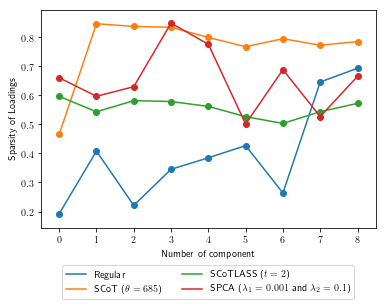

In [340]:
reg_reg = PCAObject(reg_PCA(X_small)[1], X_small, "Regular")
reg_scot_685 = PCAObject(SCoT(X_small, 685, alpha = 10**-6, max_iter = 500000), 
                         X_small, r"SCoT ($\theta = 685$)")
reg_scotlass_2 = PCAObject(SCoTLASS(X_small,2,alpha = 10**-6, max_iter=500000), 
                           X_small, r"SCoTLASS ($t = 2$)")
reg_spca_pt001 = PCAObject(SparsePCA(n_components = 9, alpha = 0.001, ridge_alpha = 0.1).fit(X_small).components_, 
                              X_small, "SPCA ($\lambda_1=0.001$ and $\lambda_2=0.1$)")

reg_reg.plotSparsity()
reg_scot_685.plotSparsity()
reg_scotlass_2.plotSparsity()
reg_spca_pt001.plotSparsity()
plt.legend(bbox_to_anchor = (0.5, -0.15), ncol = 2, loc = 'upper center')
plt.title("")
plt.savefig("../Figures/sparsityOfComponents.pdf", bbox_inches = 'tight')


In [361]:
# Create PCAObjects
reg_reg = PCAObject(reg_PCA(X_small)[1], X_small, "Regular")


reg_scot_600 = PCAObject(SCoT(X_small, 600, alpha = 10**-6, max_iter = 500000), 
                         X_small, r"SCoT ($\theta = 600$)")
reg_scot_686 = PCAObject(SCoT(X_small, 686, alpha = 10**-6, max_iter = 500000), 
                         X_small, r"SCoT ($\theta = 685$)")
reg_scot_700 = PCAObject(SCoT(X_small, 700, alpha = 10**-6, max_iter = 500000), 
                         X_small, r"SCoT ($\theta = 700$)")
reg_scot_800 = PCAObject(SCoT(X_small, 800, alpha = 10**-6, max_iter = 500000), 
                         X_small, r"SCoT ($\theta = 800$)")
reg_scot_900 = PCAObject(SCoT(X_small, 900, alpha = 10**-6, max_iter = 500000), 
                         X_small, r"SCoT ($\theta = 900$)")


reg_scotlass_1 = PCAObject(SCoTLASS(X_small,1,alpha = 10**-6, max_iter = 500000), 
                           X_small, r"SCoTLASS ($t = 1$)")
reg_scotlass_1pt5= PCAObject(SCoTLASS(X_small,1.5,alpha = 10**-6, max_iter=500000), 
                             X_small, r"SCoTLASS ($t = 1.5$)")
reg_scotlass_2 = PCAObject(SCoTLASS(X_small,2,alpha = 10**-6, max_iter=500000), 
                           X_small, r"SCoTLASS ($t = 2$)")
reg_scotlass_2pt5= PCAObject(SCoTLASS(X_small,2.5,alpha = 10**-6, max_iter=500000), 
                             X_small, r"SCoTLASS ($t = 2.5$)")

reg_spca_00001 = PCAObject(SPCA(X_small,0.0001,0.1), X_small, r"SPCA 0.0001")
reg_spca_0001 = PCAObject(SPCA(X_small,0.001,0.1), X_small, r"SPCA 0.001")
reg_spca_001 = PCAObject(SPCA(X_small,0.01,0.1), X_small, r"SPCA 0.01")
reg_spca_01 = PCAObject(SPCA(X_small,0.1,0.1), X_small, r"SPCA 0.1")

# Create lists of ordered loadings

reg_reg_ord = list(reversed(np.argsort(abs(reg_reg.pcs[0]))))+np.ones(len(reg_reg.pcs[0]))

reg_scot_500_ord = list(reversed(np.argsort(abs(reg_scot_500.pcs[0]))))+np.ones(len(reg_scot_500.pcs[0]))
reg_scot_600_ord = list(reversed(np.argsort(abs(reg_scot_600.pcs[0]))))+np.ones(len(reg_scot_600.pcs[0]))
reg_scot_700_ord = list(reversed(np.argsort(abs(reg_scot_700.pcs[0]))))+np.ones(len(reg_scot_700.pcs[0]))
reg_scot_800_ord = list(reversed(np.argsort(abs(reg_scot_800.pcs[0]))))+np.ones(len(reg_scot_800.pcs[0]))
reg_scot_900_ord = list(reversed(np.argsort(abs(reg_scot_900.pcs[0]))))+np.ones(len(reg_scot_900.pcs[0]))

reg_scotlass_1_ord = list(reversed(np.argsort(abs(reg_scotlass_1.pcs[0]))))+np.ones(len(reg_scotlass_1.pcs[0]))
reg_scotlass_1pt5_ord = list(reversed(np.argsort(abs(reg_scotlass_1pt5.pcs[0]))))+np.ones(len(reg_scotlass_1pt5.pcs[0]))
reg_scotlass_2_ord = list(reversed(np.argsort(abs(reg_scotlass_2.pcs[0]))))+np.ones(len(reg_scotlass_2.pcs[0]))
reg_scotlass_2pt5_ord = list(reversed(np.argsort(abs(reg_scotlass_2pt5.pcs[0]))))+np.ones(len(reg_scotlass_2pt5.pcs[0]))
#reg_scotlass_2pt7_ord = list(reversed(np.argsort(abs(reg_scotlass_2pt7.pcs[0]))))+np.ones(len(reg_scotlass_2pt7.pcs[0]))

reg_spca_00001_ord = list(reversed(np.argsort(abs(reg_spca_00001.pcs[0]))))+np.ones(len(reg_scotlass_1.pcs[0]))
reg_spca_0001_ord = list(reversed(np.argsort(abs(reg_spca_0001.pcs[0]))))+np.ones(len(reg_scotlass_1.pcs[0]))
reg_spca_001_ord = list(reversed(np.argsort(abs(reg_spca_001.pcs[0]))))+np.ones(len(reg_scotlass_1pt3.pcs[0]))
reg_spca_01_ord = list(reversed(np.argsort(abs(reg_spca_01.pcs[0]))))+np.ones(len(reg_scotlass_1pt5.pcs[0]))

In [266]:
# Calc EV and gini
reg_reg._calcExpVar()

reg_scot_500._calcExpVar()
reg_scot_600._calcExpVar()
reg_scot_700._calcExpVar()
reg_scot_800._calcExpVar()
reg_scot_900._calcExpVar()

reg_scotlass_1._calcExpVar()
reg_scotlass_1pt5._calcExpVar()
reg_scotlass_2._calcExpVar()
reg_scotlass_2pt5._calcExpVar()
reg_scotlass_2pt7._calcExpVar()

reg_spca_00001._calcExpVar()
reg_spca_0001._calcExpVar()
reg_spca_001._calcExpVar()
reg_spca_01._calcExpVar()

reg_scot_500._calcGini
reg_scot_600._calcGini
reg_scot_700._calcGini
reg_scot_800._calcGini
reg_scot_900._calcGini

reg_scotlass_1._calcGini
reg_scotlass_1pt5._calcGini
reg_scotlass_2._calcGini
reg_scotlass_2pt5._calcGini
reg_scotlass_2pt7._calcGini

reg_spca_00001._calcGini
reg_spca_0001._calcGini
reg_spca_001._calcGini
reg_spca_01._calcGini

<bound method PCAObject._calcGini of <__main__.PCAObject object at 0x1a18db4f98>>

In [295]:
reg_scot_685_ord = list(reversed(np.argsort(abs(reg_scot_685.pcs[0]))))+np.ones(len(reg_scot_685.pcs[0]))

ordered_loadings = np.array([reg_reg_ord,
                    reg_scot_600_ord,
                    reg_scot_685_ord,         
                    reg_scot_800_ord,
                    reg_scot_900_ord,
                    reg_scotlass_2pt5_ord,
                    reg_scotlass_2_ord,
                    reg_scotlass_1pt5_ord,
                    reg_scotlass_1_ord,
                    reg_spca_00001_ord,
                    reg_spca_0001_ord,
                    reg_spca_001_ord,
                    reg_spca_01_ord])

gini_coefs = np.array([reg_reg.gini[0],   
              reg_scot_600.gini[0], 
              reg_scot_685.gini[0],
              reg_scot_800.gini[0],
              reg_scot_900.gini[0],
              reg_scotlass_2pt5.gini[0],
              reg_scotlass_2.gini[0],
              reg_scotlass_1pt5.gini[0],                    
              reg_scotlass_1.gini[0],
              reg_spca_00001.gini[0],
              reg_spca_0001.gini[0],
              reg_spca_001.gini[0],
              reg_spca_01.gini[0]])

pevs = np.array([reg_reg.pev[0],   
              reg_scot_600.pev[0], 
              reg_scot_685.pev[0], 
              reg_scot_800.pev[0],
              reg_scot_900.pev[0],
              reg_scotlass_2pt5.pev[0],
              reg_scotlass_2.pev[0],
              reg_scotlass_1pt5.pev[0],                    
              reg_scotlass_1.pev[0],
              reg_spca_00001.pev[0],
              reg_spca_0001.pev[0],
              reg_spca_001.pev[0],
              reg_spca_01.pev[0]])

gini_coefs = np.reshape(gini_coefs,(len(gini_coefs),1))

pevs = np.reshape(pevs,(len(pevs),1))

weighted_gini = gini_coefs * pevs

df_data = np.concatenate((gini_coefs, pevs, weighted_gini, ordered_loadings), 1)

rows = ['PCA',
        'SCoT ($\theta = 600$)',
        'SCoT ($\theta = 685$)',
        'SCoT ($\theta = 800$)',
        'SCoT ($\theta = 900$)',
        'SCoTLASS ($t = 2.5$)',
        'SCoTLASS ($t = 2$)',
        'SCoTLASS ($t = 1.5$)',
        'SCoTLASS ($t = 1$)',
        'SPCA ($\lambda_1 = 0.0001$)',
        'SPCA ($\lambda_1 = 0.001$)',
        'SPCA ($\lambda_1 = 0.01$)',
        'SPCA ($\lambda_1 = 0.1$)']

cols = ['gini','pev','weighted gini']+['%d' %(i+1) for i in range(X_small.shape[1])]
ordered_load_df = pd.DataFrame(df_data,index = rows, columns = cols)
ordered_load_df = ordered_load_df.astype({'1': int, '2': int, '3': int, '4': int, '5': int, 
                                          '6': int, '7': int, '8': int, '9': int})

with open('../Tables/orderedLoads.tex', 'w') as file:
        file.write(ordered_load_df.to_latex(column_format = "rrrc|ccccccccc",
                                            float_format = "%.2f",
                                            escape = False))

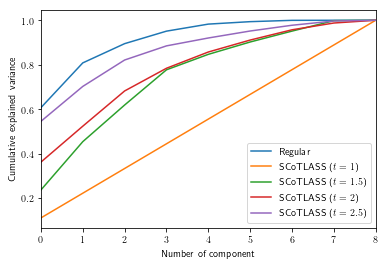

In [364]:
reg_reg.plotCEV()
reg_scotlass_1.plotCEV()
reg_scotlass_1pt5.plotCEV()
reg_scotlass_2.plotCEV()
reg_scotlass_2pt5.plotCEV()
plt.title("")
plt.savefig("../Figures/SCoTLASS_comparison.pdf", bbox_inches = 'tight')

In [294]:
loadings = np.array([reg_reg.pcs[0],
                    reg_scot_600.pcs[0],
                    reg_scot_685.pcs[0],
                    reg_scot_800.pcs[0],
                    reg_scot_900.pcs[0],
                    reg_scotlass_2pt5.pcs[0],
                    reg_scotlass_2.pcs[0],
                    reg_scotlass_1pt5.pcs[0],
                    reg_scotlass_1.pcs[0],
                    reg_spca_00001.pcs[0],
                    reg_spca_0001.pcs[0],
                    reg_spca_001.pcs[0],
                    reg_spca_01.pcs[0]])

rows = ['PCA',
        'SCoT ($\theta = 600$)',
        'SCoT ($\theta = 685$)',
        'SCoT ($\theta = 800$)',
        'SCoT ($\theta = 900$)',
        'SCoTLASS ($t = 2.5$)',
        'SCoTLASS ($t = 2$)',
        'SCoTLASS ($t = 1.5$)',
        'SCoTLASS ($t = 1$)',
        'SPCA ($\lambda_1 = 0.0001$)',
        'SPCA ($\lambda_1 = 0.001$)',
        'SPCA ($\lambda_1 = 0.01$)',
        'SPCA ($\lambda_1 = 0.1$)']

cols = ['var %d' %(i+1) for i in range(X_small.shape[1])]
load_df = pd.DataFrame(loadings,index = rows, columns = cols)
#ordered_load_df = ordered_load_df.astype({'1': int, '2': int, '3': int, '4': int, '5': int, 
#                                          '6': int, '7': int, '8': int, '9': int})

with open('../Tables/LoadingsPC1.tex', 'w') as file:
        file.write(load_df.to_latex(column_format = "r|ccccccccc",
                                            float_format = "%.2f",
                                            escape = False))